# Proyecto - Etapa 3

In [1]:
import pandas as pd
import numpy as np
import missingno as msngo
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

#Evitar avisos de deprecación entre otros.
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
 
from pylab import rcParams
 
from collections import Counter

# Carga de datos

In [2]:
datos = pd.read_excel("Diplomado_DS_Proyecto.xlsx")
#datos
datos.info() #str en R
#datos.describe() #summary en R


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDENTIFICADOR                      2143 non-null   int64  
 1   RUT_ENMASCARADO                    2143 non-null   int64  
 2   PERS_SEXO                          2143 non-null   object 
 3   FNACIMIENTO                        2130 non-null   object 
 4   EDAD                               2094 non-null   float64
 5   COD_NACIONLD                       2126 non-null   float64
 6   CODUA                              2143 non-null   int64  
 7   CODPLAN                            2143 non-null   int64  
 8   CARR_DESCRIPCION                   2143 non-null   object 
 9   FACULTAD                           2143 non-null   object 
 10  ANNIO_INGRESO                      2143 non-null   int64  
 11  SEME_INICIO                        2143 non-null   int64

In [3]:
#Análisis de variable respuesta
print(datos['SE_MATRICULA'].value_counts(normalize=True))
#print(datos['PROMEDIO_ALUMNO_EN_CARRERA'].value_counts(normalize=True))


1    0.881008
0    0.118992
Name: SE_MATRICULA, dtype: float64


In [4]:
print(datos.isnull().sum(axis=0))

IDENTIFICADOR                    0
RUT_ENMASCARADO                  0
PERS_SEXO                        0
FNACIMIENTO                     13
EDAD                            49
                                ..
TIENE_GRATUIDAD                  0
TIENE_BENEFICIO_ALIMENTACION     0
CANT_COLACIONES                  0
CANT_ALMUERZOS                   0
CANT_CENAS                       0
Length: 76, dtype: int64


In [5]:
a=datos[((datos['SE_MATRICULA']==0) & (datos['ANNIO_INGRESO'] == datos['ANNIO_MATRICULA_INDICE']))]

## Filtro y modificación datos

In [6]:
# Corresponde que estos casos particulares estén matriculados, no estaban
# matriculados porque venían de bachilleraro o traslado.
datos['SE_MATRICULA'] = np.where( (datos['SE_MATRICULA']==0) &\
     (datos['ANNIO_INGRESO'] == datos['ANNIO_MATRICULA_INDICE']),1,datos['SE_MATRICULA'])

display(datos['SE_MATRICULA'].value_counts(normalize=True))

1    0.887074
0    0.112926
Name: SE_MATRICULA, dtype: float64

In [7]:
(datos["PROMEDIO_ALUMNO_EN_CARRERA"] == 0).value_counts()

False    2093
True       50
Name: PROMEDIO_ALUMNO_EN_CARRERA, dtype: int64

In [8]:
b= datos[datos["PROMEDIO_ALUMNO_EN_CARRERA"] == 0]

In [9]:
2143-50

2093

In [10]:
#Filtra estudiantes sin notas en carrera
datos = datos.query("PROMEDIO_ALUMNO_EN_CARRERA != 0") 
#display(datos['PROMEDIO_ALUMNO_EN_CARRERA'].value_counts(normalize=True))

datos.info()

#Otra forma de Filtro
#filtro_sin_notas = datos['PROMEDIO_ALUMNO_EN_CARRERA'] != 0
#datos = datos[filtro_sin_notas]
#datos.describe(include = np.number)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2142
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDENTIFICADOR                      2093 non-null   int64  
 1   RUT_ENMASCARADO                    2093 non-null   int64  
 2   PERS_SEXO                          2093 non-null   object 
 3   FNACIMIENTO                        2080 non-null   object 
 4   EDAD                               2044 non-null   float64
 5   COD_NACIONLD                       2076 non-null   float64
 6   CODUA                              2093 non-null   int64  
 7   CODPLAN                            2093 non-null   int64  
 8   CARR_DESCRIPCION                   2093 non-null   object 
 9   FACULTAD                           2093 non-null   object 
 10  ANNIO_INGRESO                      2093 non-null   int64  
 11  SEME_INICIO                        2093 non-null   int64

In [11]:
## quitando 3 ruts duplicados -----
# Habría que ver como tratarlos, entraron 2 veces a la misma carrera
filtro_duplicados = (datos['RUT_ENMASCARADO'] != 21001132) & (datos['RUT_ENMASCARADO'] != 20024046) &\
                    (datos['RUT_ENMASCARADO'] != 20268182) 
datos = datos[filtro_duplicados]
datos.info()
#datos.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2142
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDENTIFICADOR                      2076 non-null   int64  
 1   RUT_ENMASCARADO                    2076 non-null   int64  
 2   PERS_SEXO                          2076 non-null   object 
 3   FNACIMIENTO                        2063 non-null   object 
 4   EDAD                               2027 non-null   float64
 5   COD_NACIONLD                       2059 non-null   float64
 6   CODUA                              2076 non-null   int64  
 7   CODPLAN                            2076 non-null   int64  
 8   CARR_DESCRIPCION                   2076 non-null   object 
 9   FACULTAD                           2076 non-null   object 
 10  ANNIO_INGRESO                      2076 non-null   int64  
 11  SEME_INICIO                        2076 non-null   int64

In [12]:
# cantidad de registros con la condición
datos.query("SE_MATRICULA==1")['RUT_ENMASCARADO'].count()

1869

Si se matricula y tiene en ese mismo año dos restiros temporales tomamos se matricula_N== 0, si no se hace esto en el numero de retiros temporales se contara doble vez

In [13]:
datos["SE_MATRICULA_N"]=np.where((datos["SE_MATRICULA"]==1) & (datos["CANT_RETIROS_TEMPORALES"]==2),0,datos["SE_MATRICULA"])

## Agrupación de datos por rut

In [14]:
# agrupa por rut, sin considerar matricula
# retiro temporal por semestre
# datos_group2 <- datos %>% 
#  group_by(RUT_ENMASCARADO) %>% 
#  summarise(nro_ret_temp= sum(CANT_RETIROS_TEMPORALES)/2, 
#  .groups ="drop")

#datos agrupados por rut
datos_group = datos.groupby("RUT_ENMASCARADO")

# suma cant. retiros temporales y divide por 2 (son semestrales)
datos_group = datos_group.agg({ "CANT_RETIROS_TEMPORALES" : "sum" })
display(datos_group)
datos_group["nro_ret_temp"] = datos_group["CANT_RETIROS_TEMPORALES"]/2
datos_group = datos_group.drop(columns="CANT_RETIROS_TEMPORALES")
datos_group

,CANT_RETIROS_TEMPORALES
RUT_ENMASCARADO,
14792234,0
15256444,0
15734102,0
15950623,1
16190380,0
...,...
25728092,0
25943007,0
26034894,0


,nro_ret_temp
RUT_ENMASCARADO,
14792234,0.0
15256444,0.0
15734102,0.0
15950623,0.5
16190380,0.0
...,...
25728092,0.0
25943007,0.0
26034894,0.0


In [15]:
#datos_group = summarise(nro_anioMat=n(), 
#            tot_anioMat = (2021 - min(ANNIO_INGRESO)+1),
#            .groups ="drop")

# agrupando los datos que tienen matricula
matriculados = datos.query("SE_MATRICULA_N==1") 

#datos agrupados por rut, matriculados
matr_group = matriculados.groupby('RUT_ENMASCARADO').agg({  "IDENTIFICADOR" : "count",\
                                                          #"IDENTIFICADOR" : "sum",\
                                                          "ANNIO_INGRESO" : "min" })
display(matr_group)
matr_group["nro_anioMat"] = matr_group["IDENTIFICADOR"]
matr_group["tot_anioMat"] = 2021 - matr_group["ANNIO_INGRESO"] + 1
#matr_group.query("nro_anioMat != tot_anioMat")

matr_group = matr_group.drop(columns=["IDENTIFICADOR","ANNIO_INGRESO"])
matr_group 


,IDENTIFICADOR,ANNIO_INGRESO
RUT_ENMASCARADO,,
14792234,4,2018
15256444,3,2019
15734102,4,2018
15950623,1,2017
16190380,5,2017
...,...,...
25728092,1,2021
25943007,2,2020
26034894,2,2020


,nro_anioMat,tot_anioMat
RUT_ENMASCARADO,,
14792234,4,4
15256444,3,3
15734102,4,4
15950623,1,5
16190380,5,5
...,...,...
25728092,1,1
25943007,2,2
26034894,2,2


In [16]:
# calcula variable DESERTA en base a matriculados y retiros temporales
#datos_group <- datos_group %>% 
#  mutate ( matr_y_retiro = tot_anioMat-(nro_anioMat+nro_ret_temp),
#    DESERTA = ifelse(matr_y_retiro<=0,0,1))

# mezcla 2 grupos anteriores
datos_matr_group = pd.merge(datos_group,matr_group,left_on='RUT_ENMASCARADO', right_on='RUT_ENMASCARADO')#.drop('Empleado', axis = 1) 
datos_matr_group["DESERTA"] = np.where(datos_matr_group["tot_anioMat"]-(datos_matr_group["nro_anioMat"]+datos_matr_group["nro_ret_temp"])<=0,0,1)
datos_matr_group = datos_matr_group.drop(columns=["nro_ret_temp","nro_anioMat","tot_anioMat"])
datos_matr_group

,DESERTA
RUT_ENMASCARADO,
14792234,0
15256444,0
15734102,0
15950623,1
16190380,0
...,...
25728092,0
25943007,0
26034894,0


In [17]:

datos_matr_group2 = pd.merge(datos_group,matr_group,left_on='RUT_ENMASCARADO', right_on='RUT_ENMASCARADO')#.drop('Empleado', axis = 1) 
display(datos_matr_group2)
datos_matr_group2["DESERTA"] = np.where(datos_matr_group2["tot_anioMat"]-(datos_matr_group2["nro_anioMat"])<=0,0,1)
datos_matr_group2 = datos_matr_group2.drop(columns=["nro_ret_temp","nro_anioMat","tot_anioMat"])
datos_matr_group2

,nro_ret_temp,nro_anioMat,tot_anioMat
RUT_ENMASCARADO,,,
14792234,0.0,4,4
15256444,0.0,3,3
15734102,0.0,4,4
15950623,0.5,1,5
16190380,0.0,5,5
...,...,...,...
25728092,0.0,1,1
25943007,0.0,2,2
26034894,0.0,2,2


,DESERTA
RUT_ENMASCARADO,
14792234,0
15256444,0
15734102,0
15950623,1
16190380,0
...,...
25728092,0
25943007,0
26034894,0


In [18]:
display(datos_matr_group2["DESERTA"].value_counts())
display(datos_matr_group["DESERTA"].value_counts())

0    535
1     98
Name: DESERTA, dtype: int64

0    542
1     91
Name: DESERTA, dtype: int64

0    541
1     92

0    543
1     90


In [19]:
datos_matr_group[datos_matr_group["DESERTA"]==0].value_counts()

DESERTA
0          542
dtype: int64

In [20]:
# datos_matr_group.reset_index(inplace=True)
# datos_matr_group2.reset_index(inplace=True)


In [21]:
datos_matr_group2[datos_matr_group2["DESERTA"]!=datos_matr_group["DESERTA"] ]

,DESERTA
RUT_ENMASCARADO,
19202784,1
19519028,1
19551925,1
20006174,1
20022677,1
20838235,1
21051495,1


In [22]:
datos_matr_group2[datos_matr_group2["DESERTA"]!=datos_matr_group["DESERTA"] ]

,DESERTA
RUT_ENMASCARADO,
19202784,1
19519028,1
19551925,1
20006174,1
20022677,1
20838235,1
21051495,1


Codigos de dos estudiantes que si hago la forula deserta= Total_matricula - Numero_matricula>0 entonces deserto, 
si tomamos la diferencia de esos dos grupos solo hay dos estudiantes por fuera. Los analice y uno efectivamente tuvo en los ultimos años retiros temporales por tanto aun no ha desetado, pero la otra en el 2020 matriculo pero hizo dos restiros en el mismo año, y el 2021 ya no matriculo y no hizo ningun retiro , asi que se debe considerar como que deserto.
datos_matr_group2[datos_matr_group2["DESERTA"]!=datos_matr_group["DESERTA"] ]
RUT_ENMASCARADO	DESERTA
178	20006174	1
306	20305527	1

In [23]:
c=datos[(datos["SE_MATRICULA"]==1) & (datos["CANT_RETIROS_TEMPORALES"]>0)]

## Mezcla data con datos agrupados

In [24]:
# mezcla completa
datos_merge = pd.merge(datos,datos_matr_group,left_on='RUT_ENMASCARADO', right_on='RUT_ENMASCARADO')#.drop('RUT_ENMASCARADO', axis = 1) 
datos_merge

,IDENTIFICADOR,RUT_ENMASCARADO,PERS_SEXO,FNACIMIENTO,EDAD,COD_NACIONLD,CODUA,CODPLAN,CARR_DESCRIPCION,FACULTAD,...,CANT_RAMOS_OP2,CANT_RAMOS_OP3,CANT_RAMOS_OP4,TIENE_GRATUIDAD,TIENE_BENEFICIO_ALIMENTACION,CANT_COLACIONES,CANT_ALMUERZOS,CANT_CENAS,SE_MATRICULA_N,DESERTA
0,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
1,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
2,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
3,1479223433532018,14792234,F,1999-11-04 00:00:00,22.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,2,0,0,1,0,0,0,0,1,0
4,1525644433532019,15256444,F,2000-11-06 00:00:00,21.0,1.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,2594300733532020,25943007,M,2001-12-16 00:00:00,20.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,5,0,0,1,0,0,0,0,1,0
2072,2603489433532020,26034894,F,2001-11-09 00:00:00,20.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,0,0,0,1,0,0,0,0,1,0
2073,2603489433532020,26034894,F,2001-11-09 00:00:00,20.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,0,0,0,1,0,0,0,0,1,0
2074,2627009333532021,26270093,F,2002-12-20 00:00:00,19.0,2.0,3353,3,3353- INGENIERIA COMERCIAL MENCION NEGOCIOS MI...,FACULTAD DE INGENIERIA,...,0,0,0,1,0,0,0,0,1,0


## Limpieza de la mezcla

In [25]:
# limpieza de la mezcla 
datos_clean = datos_merge.drop(columns=["CODPLAN", "SE_MATRICULA",
           "ANNIO_MATRICULA_INDICE", "PROM_NOTA_SEM1", "PROM_NOTA_SEM2",
            "NUMEROCURSOSAPROBADOS_S1", "NUMEROCURSOSAPROBADOS_S2",
            "NUMEROCURSOSINSCRITOS_S1", "NUMEROCURSOSINSCRITOS_S2",
            "IDENTIFICADOR", "FNACIMIENTO", "CARR_DESCRIPCION", "FACULTAD",
            "COD_ESTADO_PLAN", "ESTADO_PLAN_TEXTO", "AGNO_PROCESO","PROMEDIO_ANUAL",
            "SEME_INICIO", "PERS_COMENTARIO", "FACTUAL","DEUDA_DAA",#"ANNIO_INGRESO"
            "TOTAL_DEUDA", "CANT_RETIROS_TEMPORALES", "CANT_ALMUERZOS", "DEUDA_DAA",
            "CANT_DEUDAS_DISTINTAS_EN_EL_ANNIO", "TIENE_BENEFICIO_ALIMENTACION",
            "DEUDA_ARA", "DEUDA_MAT", "DEUDA_COB", "DEUDA_CUA", 
            "TIENE_DEUDA_ARA", "TIENE_DEUDA_DAA", "TIENE_DEUDA_MAT","TIENE_GRATUIDAD",
            "TIENE_DEUDA_COB", "TIENE_DEUDA_CUA", "CANT_COLACIONES", "CANT_CENAS","SE_MATRICULA_N" ]) # con una sola categoria (0)

datos_clean.to_csv('datos_clean.csv')

datos_clean


,RUT_ENMASCARADO,PERS_SEXO,EDAD,COD_NACIONLD,CODUA,ANNIO_INGRESO,RAMA_EDUCACIONAL,REGION_ESTAB_EDUC,PROVINCIA_ESTAB_EDUC,COMUNA_ESTAB_EDUC,...,PROMEDIO_PRIMER_ANNIO,PROMEDIO_ALUMNO_EN_CARRERA,CANT_RAMOS_INSCRITOS_CARRERA,CANT_RAMOS_APROBADOS_CARRERA,CANT_RAMOS_PLAN_CARRERA,PORCENTAJE_AVANCE_CARRERA,CANT_RAMOS_OP2,CANT_RAMOS_OP3,CANT_RAMOS_OP4,DESERTA
0,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
1,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
2,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
3,14792234,F,22.0,1.0,3353,2018,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.73,5.44,48,46,56,82.14,2,0,0,0
4,15256444,F,21.0,1.0,3353,2019,T3,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.84,5.06,36,32,56,57.14,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,25943007,M,20.0,2.0,3353,2020,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,1.00,1.30,12,1,56,1.79,5,0,0,0
2072,26034894,F,20.0,2.0,3353,2020,T1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,5.35,5.21,24,21,56,37.50,0,0,0,0
2073,26034894,F,20.0,2.0,3353,2020,T1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,5.35,5.21,24,21,56,37.50,0,0,0,0
2074,26270093,F,19.0,2.0,3353,2021,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,ANTOFAGASTA,...,4.28,4.28,13,12,56,21.43,0,0,0,0


## Quitar duplicados

In [26]:
# # quitar duplicados
datos_clean2 =datos_clean[~datos_clean.duplicated()]
datos_clean2.info()

# quitar duplicados
#datos_clean2 =datos_merge[~datos_merge.duplicated()]
#datos_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 0 to 2075
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RUT_ENMASCARADO               633 non-null    int64  
 1   PERS_SEXO                     633 non-null    object 
 2   EDAD                          618 non-null    float64
 3   COD_NACIONLD                  629 non-null    float64
 4   CODUA                         633 non-null    int64  
 5   ANNIO_INGRESO                 633 non-null    int64  
 6   RAMA_EDUCACIONAL              566 non-null    object 
 7   REGION_ESTAB_EDUC             567 non-null    object 
 8   PROVINCIA_ESTAB_EDUC          567 non-null    object 
 9   COMUNA_ESTAB_EDUC             412 non-null    object 
 10  BEA                           53 non-null     object 
 11  DIR_REGION                    461 non-null    object 
 12  DIR_PROVINCIA                 461 non-null    object 
 13  DIR_

Bajar la data

## Revisión de NAs

Visualización de NAs

<AxesSubplot:>

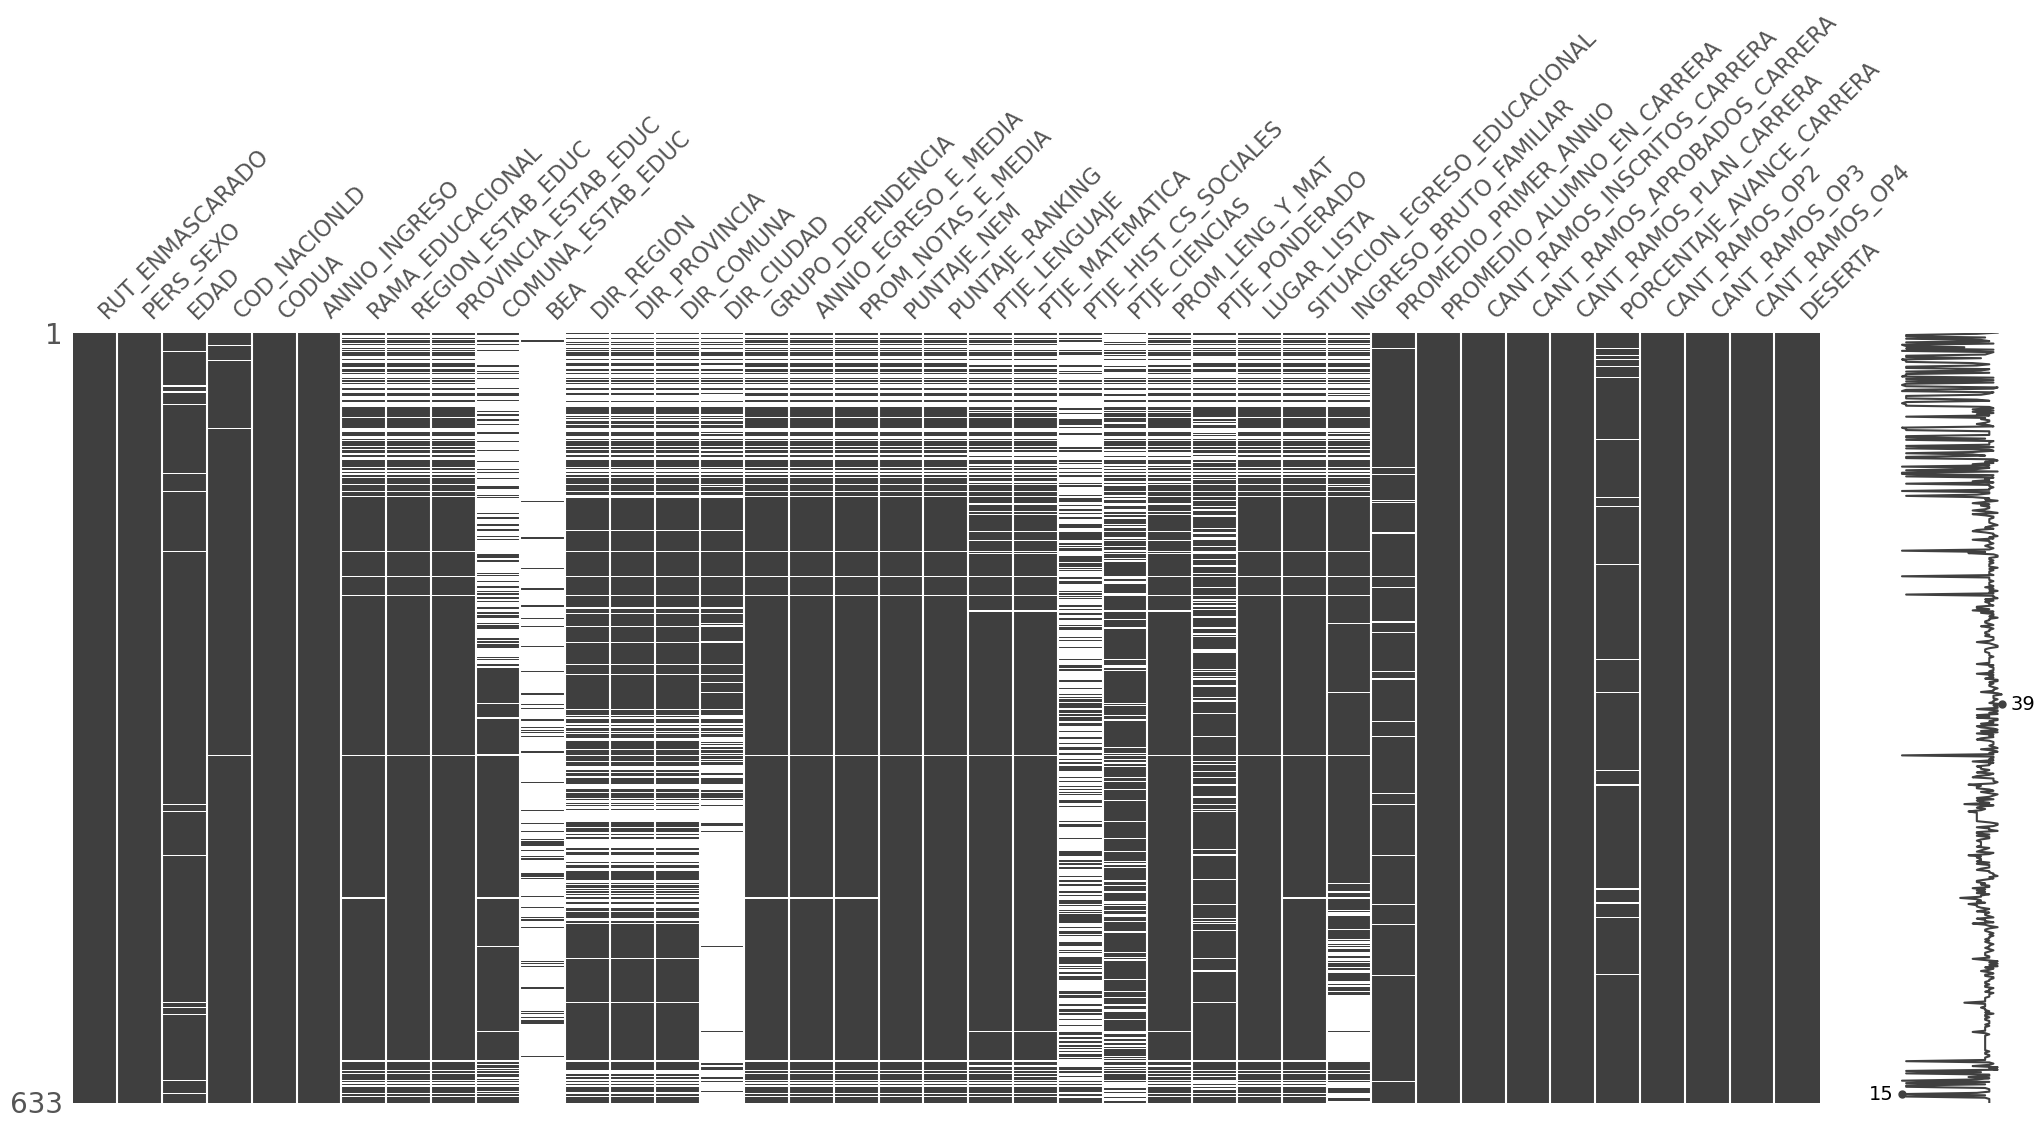

In [27]:
msngo.matrix(datos_clean2)

Eliminación variables con demasiados NAs

In [28]:
datos_clean2 = datos_clean2.drop(columns=["DIR_CIUDAD","COMUNA_ESTAB_EDUC","LUGAR_LISTA",\
"DIR_REGION","DIR_COMUNA","DIR_PROVINCIA"])
#"PTJE_HIST_CS_SOCIALES","PTJE_CIENCIAS","BEA",
# se matriucla n solo es para

<AxesSubplot:>

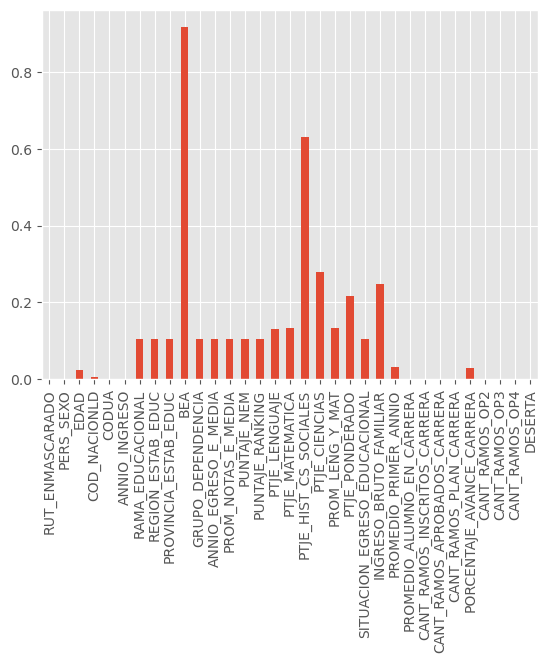

In [29]:
datos_clean2.isna().mean().plot(kind="bar")

## Transformación de variables

DESERTA

In [30]:
# datos_clean2["DESERTA"] = np.where(datos_clean2["DESERTA"]==1,'Si','No')
# print(datos_clean2["DESERTA"].value_counts())
# print(datos_clean2['DESERTA'].value_counts(normalize=True))
# 14% Verdaderos 86% Falsos

CODUA

In [31]:
datos_clean2["CODUA"] = np.where(datos_clean2["CODUA"]==3353,'Ingeco','Enfermeria')
print(datos_clean2["CODUA"].value_counts())

Ingeco        342
Enfermeria    291
Name: CODUA, dtype: int64


BEA: consultar si tiene incidencia contar o no con ella. Bajo % con beca (se prueba)

In [32]:
datos_clean2["BEA"] = np.where(~datos_clean2["BEA"].isna(), "BEA", "SIN BEA")
print(datos_clean2["BEA"].value_counts(normalize=True))
print(datos_clean2["BEA"].value_counts())


SIN BEA    0.916272
BEA        0.083728
Name: BEA, dtype: float64
SIN BEA    580
BEA         53
Name: BEA, dtype: int64


In [33]:
datos_clean2["EDAD"].isna().value_counts()

False    618
True      15
Name: EDAD, dtype: int64

EDAD

In [34]:
datos_clean2[~datos_clean2["ANNIO_EGRESO_E_MEDIA"].isna()]["ANNIO_EGRESO_E_MEDIA"]

0       2017.0
4       2018.0
16      2003.0
23      2018.0
26      2006.0
         ...  
2069    2020.0
2070    2019.0
2072    2019.0
2074    2020.0
2075    2020.0
Name: ANNIO_EGRESO_E_MEDIA, Length: 566, dtype: float64

In [35]:
datos_clean2[datos_clean2["EDAD"].isna()]["ANNIO_EGRESO_E_MEDIA"].isna().value_counts()

True     9
False    6
Name: ANNIO_EGRESO_E_MEDIA, dtype: int64

In [36]:
datos_clean2[datos_clean2["EDAD"].isna()][["ANNIO_INGRESO","ANNIO_EGRESO_E_MEDIA"]]

,ANNIO_INGRESO,ANNIO_EGRESO_E_MEDIA
62,2017,NaN
189,2017,NaN
213,2018,NaN
250,2018,NaN
491,2018,NaN
556,2019,NaN
779,2019,NaN
1571,2019,2018.0
1589,2020,2018.0
1686,2019,2018.0


In [37]:
pd.options.display.float_format = '{:.2f}'.format



In [38]:
datos_clean2[~datos_clean2["EDAD"].isna()].mean()

RUT_ENMASCARADO                20395981.03
EDAD                                 22.62
COD_NACIONLD                          1.04
ANNIO_INGRESO                      2018.72
GRUPO_DEPENDENCIA                     2.24
ANNIO_EGRESO_E_MEDIA               2017.09
PROM_NOTAS_E_MEDIA                    5.84
PUNTAJE_NEM                         605.10
PUNTAJE_RANKING                     636.32
PTJE_LENGUAJE                       535.37
PTJE_MATEMATICA                     541.14
PTJE_HIST_CS_SOCIALES               522.22
PTJE_CIENCIAS                       529.70
PROM_LENG_Y_MAT                     538.34
PTJE_PONDERADO                      598.76
SITUACION_EGRESO_EDUCACIONAL          2.22
INGRESO_BRUTO_FAMILIAR                5.70
PROMEDIO_PRIMER_ANNIO                 4.97
PROMEDIO_ALUMNO_EN_CARRERA            5.01
CANT_RAMOS_INSCRITOS_CARRERA         30.74
CANT_RAMOS_APROBADOS_CARRERA         27.55
CANT_RAMOS_PLAN_CARRERA              56.00
PORCENTAJE_AVANCE_CARRERA            50.67
CANT_RAMOS_

In [39]:
datos_clean2[~datos_clean2["EDAD"].isna()].mode()

,RUT_ENMASCARADO,PERS_SEXO,EDAD,COD_NACIONLD,CODUA,ANNIO_INGRESO,RAMA_EDUCACIONAL,REGION_ESTAB_EDUC,PROVINCIA_ESTAB_EDUC,BEA,...,PROMEDIO_PRIMER_ANNIO,PROMEDIO_ALUMNO_EN_CARRERA,CANT_RAMOS_INSCRITOS_CARRERA,CANT_RAMOS_APROBADOS_CARRERA,CANT_RAMOS_PLAN_CARRERA,PORCENTAJE_AVANCE_CARRERA,CANT_RAMOS_OP2,CANT_RAMOS_OP3,CANT_RAMOS_OP4,DESERTA
0,14792234,F,22.00,1.00,Ingeco,2017.00,H1,REGION DE ANTOFAGASTA,ANTOFAGASTA,SIN BEA,...,5.30,5.94,12.00,12.00,56.00,21.43,0.00,0.00,0.00,0.00
1,15256444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15734102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15950623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16190380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,25728092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
614,25943007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615,26034894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,26270093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
datos_clean2[~datos_clean2["EDAD"].isna()].median()

RUT_ENMASCARADO                20316208.00
EDAD                                 22.00
COD_NACIONLD                          1.00
ANNIO_INGRESO                      2019.00
GRUPO_DEPENDENCIA                     2.00
ANNIO_EGRESO_E_MEDIA               2017.00
PROM_NOTAS_E_MEDIA                    6.00
PUNTAJE_NEM                         626.00
PUNTAJE_RANKING                     657.00
PTJE_LENGUAJE                       534.00
PTJE_MATEMATICA                     544.00
PTJE_HIST_CS_SOCIALES               518.00
PTJE_CIENCIAS                       535.00
PROM_LENG_Y_MAT                     539.50
PTJE_PONDERADO                      607.00
SITUACION_EGRESO_EDUCACIONAL          1.00
INGRESO_BRUTO_FAMILIAR                6.00
PROMEDIO_PRIMER_ANNIO                 5.26
PROMEDIO_ALUMNO_EN_CARRERA            5.37
CANT_RAMOS_INSCRITOS_CARRERA         32.00
CANT_RAMOS_APROBADOS_CARRERA         26.00
CANT_RAMOS_PLAN_CARRERA              56.00
PORCENTAJE_AVANCE_CARRERA            48.21
CANT_RAMOS_

In [41]:
~datos_clean2["EDAD"].isna()

0       True
4       True
7       True
11      True
16      True
        ... 
2069    True
2070    True
2072    True
2074    True
2075    True
Name: EDAD, Length: 633, dtype: bool

In [43]:
#from asyncio.windows_events import NULL

from numpy import NaN


datos_clean2["EDAD2"] = np.where(~datos_clean2["EDAD"].isna(), np.select(
    condlist = [datos_clean2["EDAD"] <=23,
                datos_clean2["EDAD"] <= 27,
                datos_clean2["EDAD"] <= 31,
                datos_clean2["EDAD"] <= 35,
                datos_clean2["EDAD"] <= 40 ],
    choicelist = [ "Edad 17-23", "Edad 24-26", "Edad 27-30", "Edad 31-34", "Edad 35-39" ],
    default    = "Otra edad"), NaN
)
#datos_clean2.query("EDAD=='Edad 17-23'")["EDAD"].count()
print(datos_clean2["EDAD2"].value_counts())


Edad 17-23    446
Edad 24-26    139
Edad 27-30     23
nan            15
Edad 35-39      5
Edad 31-34      5
Name: EDAD2, dtype: int64


In [44]:
datos_clean2[datos_clean2["RUT_ENMASCARADO"]==18289782].isna()

,RUT_ENMASCARADO,PERS_SEXO,EDAD,COD_NACIONLD,CODUA,ANNIO_INGRESO,RAMA_EDUCACIONAL,REGION_ESTAB_EDUC,PROVINCIA_ESTAB_EDUC,BEA,...,PROMEDIO_ALUMNO_EN_CARRERA,CANT_RAMOS_INSCRITOS_CARRERA,CANT_RAMOS_APROBADOS_CARRERA,CANT_RAMOS_PLAN_CARRERA,PORCENTAJE_AVANCE_CARRERA,CANT_RAMOS_OP2,CANT_RAMOS_OP3,CANT_RAMOS_OP4,DESERTA,EDAD2
62,False,False,True,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


INGRESO_BRUTO_FAMILIAR

In [45]:

datos_clean2["INGRESO_BRUTO_FAMILIAR"] = np.where(~datos_clean2["INGRESO_BRUTO_FAMILIAR"].isna(), np.select( 
    condlist   = [datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 1.0, \
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 2.0, 
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 3.0,
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 4.0,
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 5.0,
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 6.0,
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 7.0,
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 8.0,
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 9.0,
                  datos_clean2["INGRESO_BRUTO_FAMILIAR"] == 10.0 ],
    choicelist = ["1º decil", "2º decil", "3º decil", "4º decil", "5º decil",
                  "6º decil", "7º decil", "8º decil", "9º decil", "10º decil"],
    default    = "Otro decil" ), datos_clean2["INGRESO_BRUTO_FAMILIAR"]
)

print(datos_clean2["INGRESO_BRUTO_FAMILIAR"].value_counts())


nan           157
2º decil       56
3º decil       56
10º decil      54
4º decil       53
6º decil       47
5º decil       47
7º decil       46
8º decil       45
9º decil       43
1º decil       23
Otro decil      6
Name: INGRESO_BRUTO_FAMILIAR, dtype: int64


COD_NACIONLD: la mayoría es chileno, poca incidencia, se elimina variable

In [46]:
datos_clean2["COD_NACIONLD"] = np.where(~datos_clean2["COD_NACIONLD"].isna(),
                                        np.where(datos_clean2["COD_NACIONLD"]==1,"Chileno","Extranjero"),
                                        datos_clean2["COD_NACIONLD"])
print(datos_clean2["COD_NACIONLD"].value_counts())   
# Chileno       602
# Extranjero     27

# se elimina variable
datos_clean2 = datos_clean2.drop("COD_NACIONLD", axis=1)                                

Chileno       602
Extranjero     27
nan             4
Name: COD_NACIONLD, dtype: int64


REGION_ESTAB_EDUC: La mayoría de Reg. Antof, poca incidencia. Se elimina variable

In [47]:
datos_clean2["REGION_ESTAB_EDUC"] = np.where(~datos_clean2["REGION_ESTAB_EDUC"].isna(),
                                        np.where(datos_clean2["REGION_ESTAB_EDUC"]=='REGION DE ANTOFAGASTA',
                                        "REGION DE ANTOFAGASTA","OTRA REGION"),
                                        datos_clean2["REGION_ESTAB_EDUC"])
print(datos_clean2["REGION_ESTAB_EDUC"].value_counts())  

# se elimina variable
datos_clean2 = datos_clean2.drop("REGION_ESTAB_EDUC", axis=1)  

REGION DE ANTOFAGASTA    531
OTRA REGION               36
Name: REGION_ESTAB_EDUC, dtype: int64


PROVINCIA_ESTAB_EDUC

In [48]:
#print(datos_clean2["PROVINCIA_ESTAB_EDUC"].value_counts())  
datos_clean2["PROVINCIA_ESTAB_EDUC"] = np.where(~datos_clean2["PROVINCIA_ESTAB_EDUC"].isna(),\
                                           np.where(datos_clean2["PROVINCIA_ESTAB_EDUC"]!="ANTOFAGASTA",\
                                              np.where(datos_clean2["PROVINCIA_ESTAB_EDUC"]!="EL LOA",\
                                                 np.where( datos_clean2["PROVINCIA_ESTAB_EDUC"]!="TOCOPILLA",\
                                                    "OTRA PROVINCIA", datos_clean2["PROVINCIA_ESTAB_EDUC"]),\
                                              datos_clean2["PROVINCIA_ESTAB_EDUC"]),\
                                           datos_clean2["PROVINCIA_ESTAB_EDUC"]),\
                                        datos_clean2["PROVINCIA_ESTAB_EDUC"])
print(datos_clean2["PROVINCIA_ESTAB_EDUC"].value_counts())  


ANTOFAGASTA       439
EL LOA             75
OTRA PROVINCIA     36
TOCOPILLA          17
Name: PROVINCIA_ESTAB_EDUC, dtype: int64


ANNIO_EGRESO_E_MEDIA

In [49]:
datos_clean2["ANNIO_EGRESO_E_MEDIA"] = np.where(~datos_clean2["ANNIO_EGRESO_E_MEDIA"].isna(), 
                                                np.select(
                                                   condlist = [datos_clean2["ANNIO_EGRESO_E_MEDIA"]<2012.0,
                                                               datos_clean2["ANNIO_EGRESO_E_MEDIA"]<2015.0],
                                                  choicelist = [ "Egreso media 2003-2011", 
                                                                 "Egreso media 2012-2014" ], 
                                                  default    = "Egreso media 2015-2020"), 
                                                datos_clean2["ANNIO_EGRESO_E_MEDIA"] )

print(datos_clean2["ANNIO_EGRESO_E_MEDIA"].value_counts())  


Egreso media 2015-2020    526
nan                        67
Egreso media 2012-2014     29
Egreso media 2003-2011     11
Name: ANNIO_EGRESO_E_MEDIA, dtype: int64


SITUACION_EGRESO_EDUCACIONAL

In [50]:
datos_clean2["SITUACION_EGRESO_EDUCACIONAL"] = np.where(datos_clean2["SITUACION_EGRESO_EDUCACIONAL"].notnull(), 
                                               np.select(
                                                condlist = [datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==1,
                                                            datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==3,
                                                            datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==4,
                                                            datos_clean2["SITUACION_EGRESO_EDUCACIONAL"]==5],
                                                choicelist = [ "Prom.Año: Nac–alumno regular", 
                                                               "Prom.Año: Extr–con algún curso en Chile",
                                                               "Prom.Año: Extr–no acredita notas",
                                                               "Prom.Ant: Nac–alumno regular"], 
                                                default    = "Otra situacion"), 
                                               datos_clean2["SITUACION_EGRESO_EDUCACIONAL"] )

print(datos_clean2["SITUACION_EGRESO_EDUCACIONAL"].value_counts())  
#Prom.Año: Nac–alumno regular     395
#Prom.Ant: Nac–alumno regular     169
#nan                               67
#Prom.Ant: Nac–valid. estudios      1
#Prom.Año: Nac–valid. estudios      1

# estos ultimos 2 los transforme en 'Otra situacion'


Prom.Año: Nac–alumno regular    395
Prom.Ant: Nac–alumno regular    169
nan                              67
Otra situacion                    2
Name: SITUACION_EGRESO_EDUCACIONAL, dtype: int64


LUGAR_LISTA: eliminado, no dice mucho

In [51]:
from cmath import isnan
from math import nan

#cantidad de NA
#datos_clean2.isna().sum()
#datos_clean2["LUGAR_LISTA"].isna().sum()

#print(datos_clean2["LUGAR_LISTA"].value_counts())   
# 93 casos = 0
# 66 casos nulos

# datos_clean2["LUGAR_LISTA"] = np.where(datos_clean2["LUGAR_LISTA"].notnull(), 
#                                                np.select(
#                                                 condlist = [datos_clean2["LUGAR_LISTA"]==0,
#                                                             datos_clean2["LUGAR_LISTA"]<30,
#                                                             datos_clean2["LUGAR_LISTA"]<60,
#                                                             datos_clean2["LUGAR_LISTA"]<90,
#                                                             datos_clean2["LUGAR_LISTA"]<120 ],
#                                                 choicelist = [ nan, 
#                                                                "G1 Lista",
#                                                                "G2 Lista",
#                                                                "G3 Lista",
#                                                                "G4 Lista"], 
#                                                 default    = "G5 lista"), 
#                                                datos_clean2["LUGAR_LISTA"] )

# print(datos_clean2["LUGAR_LISTA"].value_counts())  


# 159 NA


GRUPO_DEPENDENCIA

In [52]:
datos_clean2["GRUPO_DEPENDENCIA"] = np.where(~datos_clean2["GRUPO_DEPENDENCIA"].isna(), 
                                               np.select(
                                                condlist = [datos_clean2["GRUPO_DEPENDENCIA"]==1,
                                                            datos_clean2["GRUPO_DEPENDENCIA"]==2,
                                                            datos_clean2["GRUPO_DEPENDENCIA"]==3 ],
                                                choicelist = [ "Particular Pagado", 
                                                               "Particular Subvencionado",
                                                               "Municipal" ], 
                                                default    = "Servicio Local de Educacion"), 
                                               datos_clean2["GRUPO_DEPENDENCIA"] )

print(datos_clean2["GRUPO_DEPENDENCIA"].value_counts())  


Particular Subvencionado       277
Municipal                      210
Particular Pagado               75
nan                             67
Servicio Local de Educacion      4
Name: GRUPO_DEPENDENCIA, dtype: int64


In [53]:
# Eliminación RUT enmascarado
datos_clean2 = datos_clean2.drop(columns=["RUT_ENMASCARADO"])
datos_clean2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 0 to 2075
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PERS_SEXO                     633 non-null    object 
 1   EDAD                          633 non-null    object 
 2   CODUA                         633 non-null    object 
 3   ANNIO_INGRESO                 633 non-null    int64  
 4   RAMA_EDUCACIONAL              566 non-null    object 
 5   PROVINCIA_ESTAB_EDUC          567 non-null    object 
 6   BEA                           633 non-null    object 
 7   GRUPO_DEPENDENCIA             633 non-null    object 
 8   ANNIO_EGRESO_E_MEDIA          633 non-null    object 
 9   PROM_NOTAS_E_MEDIA            566 non-null    float64
 10  PUNTAJE_NEM                   567 non-null    float64
 11  PUNTAJE_RANKING               567 non-null    float64
 12  PTJE_LENGUAJE                 550 non-null    float64
 13  PTJE

Limpia los NAs despues de trasformar variables

In [54]:
#Completa los NA's
datos_clean2 = datos_clean2.fillna({'RAMA_EDUCACIONAL': 'H1',\
              'EDAD': "Edad 17-23",\
              'REGION_ESTAB_EDUC': 'REGION DE ANTOFAGASTA',\
              'PROVINCIA_ESTAB_EDUC': 'ANTOFAGASTA',\
              'GRUPO_DEPENDENCIA': 'Particular Subvencionado',\
              'ANNIO_EGRESO_E_MEDIA': 'Egreso media 2015-2020',\
              'PROMEDIO_PRIMER_ANNIO': datos_clean2['PROMEDIO_PRIMER_ANNIO'].mean(),\
              'PROM_NOTAS_E_MEDIA': datos_clean2['PROM_NOTAS_E_MEDIA'].mean(),\
              'PUNTAJE_NEM': datos_clean2['PUNTAJE_NEM'].mean(),\
              'PUNTAJE_RANKING': datos_clean2['PUNTAJE_RANKING'].mean(),\
              'PTJE_LENGUAJE': datos_clean2['PTJE_LENGUAJE'].mean(),\
              'PTJE_MATEMATICA': datos_clean2['PTJE_MATEMATICA'].mean(),\
              'PROM_LENG_Y_MAT': datos_clean2['PROM_LENG_Y_MAT'].mean(),\
              'PTJE_PONDERADO': datos_clean2['PTJE_PONDERADO'].mean(),\
              'PTJE_CIENCIAS': datos_clean2['PTJE_CIENCIAS'].mean(),\
              'SITUACION_EGRESO_EDUCACIONAL': 'Prom.Año: Nac–alumno regular',\
              'INGRESO_BRUTO_FAMILIAR': '2º decil',\
             #'PORCENTAJE_AVANCE_CARRERA': datos_clean2['PORCENTAJE_AVANCE_CARRERA'].median(),\
             'PTJE_HIST_CS_SOCIALES': datos_clean2['PTJE_HIST_CS_SOCIALES'].mean(),\
            'PROMEDIO_ALUMNO_EN_CARRERA': datos_clean2['PROMEDIO_ALUMNO_EN_CARRERA'].mean()
               })  



In [55]:
PorcePromAnioIngreso = datos_clean2.groupby("ANNIO_INGRESO").mean()["PORCENTAJE_AVANCE_CARRERA"]
display(PorcePromAnioIngreso)

ANNIO_INGRESO
2017   70.71
2018   62.77
2019   47.51
2020   34.16
2021   19.16
Name: PORCENTAJE_AVANCE_CARRERA, dtype: float64

In [56]:
PorceAvance=pd.merge(datos_clean2.loc[:,datos_clean2.columns!="PORCENTAJE_AVANCE_CARRERA"],PorcePromAnioIngreso, left_on="ANNIO_INGRESO",right_on="ANNIO_INGRESO")

In [57]:
PorceAvance["PORCENTAJE_AVANCE_CARRERA"]

0     62.77
1     62.77
2     62.77
3     62.77
4     62.77
       ... 
628   19.16
629   19.16
630   19.16
631   19.16
632   19.16
Name: PORCENTAJE_AVANCE_CARRERA, Length: 633, dtype: float64

In [58]:
datos_clean2["PORCENTAJE_AVANCE_CARRERA"]=np.where((datos_clean2["PORCENTAJE_AVANCE_CARRERA"].isna()), PorceAvance["PORCENTAJE_AVANCE_CARRERA"], datos_clean2["PORCENTAJE_AVANCE_CARRERA"])

In [59]:
datos_clean2["PORCENTAJE_AVANCE_CARRERA"].isna().sum()

0

2da Visualización de NA

<AxesSubplot:>

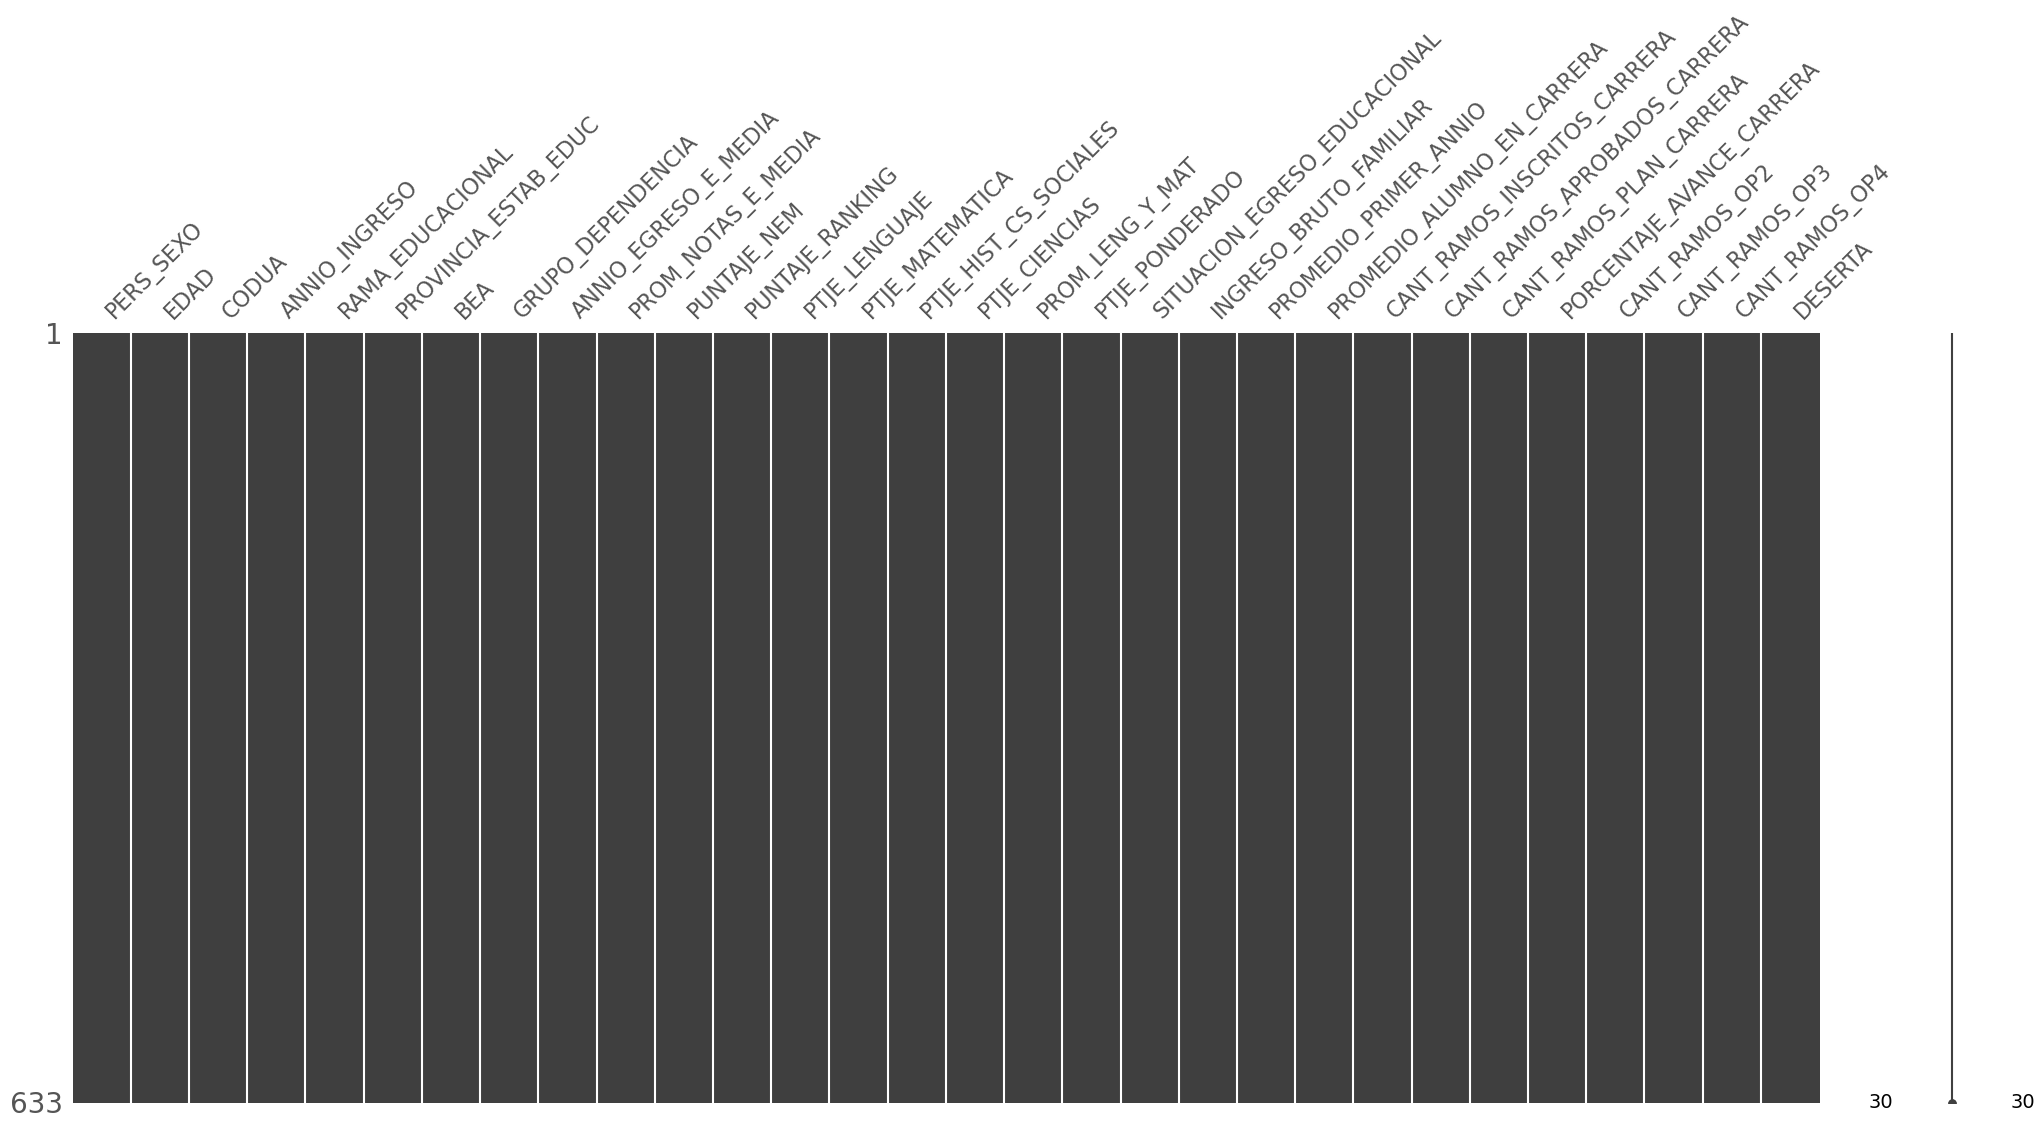

In [64]:
msngo.matrix(datos_clean2)

In [61]:
datos_clean2.to_csv('datosLimpios.csv')

In [63]:
datos_clean2["INGRESO_BRUTO_FAMILIAR"]

0       2º decil
4       2º decil
7            nan
11           nan
16      8º decil
          ...   
2069         nan
2070    4º decil
2072    3º decil
2074         nan
2075         nan
Name: INGRESO_BRUTO_FAMILIAR, Length: 633, dtype: object

Análisis Descriptivo

In [62]:
# análisis descriptivo de variables numericas
datos_clean2.describe(datetime_is_numeric=True).T

#     CANT_RAMOS_OP4	media=	0.036335  se podría eliminar

,count,mean,std,min,25%,50%,75%,max
ANNIO_INGRESO,633.00,2018.72,1.42,2017.00,2017.00,2019.00,2020.00,2021.00
PROM_NOTAS_E_MEDIA,633.00,5.84,0.48,4.00,5.50,5.88,6.20,6.90
PUNTAJE_NEM,633.00,605.29,98.69,374.00,528.00,605.29,686.00,829.00
PUNTAJE_RANKING,633.00,636.51,122.36,374.00,537.00,636.51,736.00,850.00
PTJE_LENGUAJE,633.00,535.00,79.38,273.00,491.00,535.00,582.00,773.00
PTJE_MATEMATICA,633.00,540.86,75.81,212.00,507.00,540.86,591.00,719.00
PTJE_HIST_CS_SOCIALES,633.00,522.74,68.13,210.00,522.74,522.74,522.74,850.00
PTJE_CIENCIAS,633.00,529.04,77.65,257.00,501.00,529.04,576.00,727.00
PROM_LENG_Y_MAT,633.00,538.01,69.31,258.50,498.00,538.01,584.50,728.00
PTJE_PONDERADO,633.00,599.08,78.93,424.00,537.00,599.08,647.00,914.00


In [58]:
# descripcion variables categoricas
datos_clean2.describe(include="object")

,PERS_SEXO,EDAD,CODUA,RAMA_EDUCACIONAL,PROVINCIA_ESTAB_EDUC,BEA,GRUPO_DEPENDENCIA,ANNIO_EGRESO_E_MEDIA,SITUACION_EGRESO_EDUCACIONAL,INGRESO_BRUTO_FAMILIAR
count,856,856,856,856,856,856,856,856,856,856
unique,2,6,2,6,4,2,5,4,4,12
top,F,Edad 17-23,Ingeco,H1,ANTOFAGASTA,SIN BEA,Particular Subvencionado,Egreso media 2015-2020,Prom.Año: Nac–alumno regular,nan
freq,525,398,481,686,692,792,363,676,483,213


Análisis de la variable respuesta

In [59]:
print(pd.crosstab(index=datos_clean2['DESERTA'], columns='count'))
print(datos_clean2['DESERTA'].value_counts(normalize=True))

col_0    count
DESERTA       
0          711
1          145
0   0.83
1   0.17
Name: DESERTA, dtype: float64


Text(0, 0.5, 'N° de Observaciones')

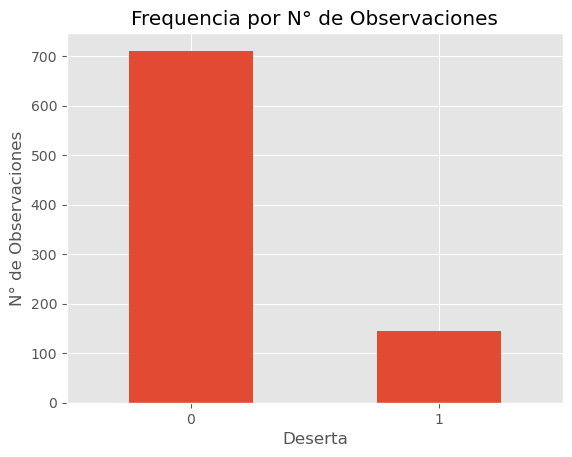

In [60]:
#datos_clean2["DESERTA"]
#datos_clean2.mean('DESERTA')

count_classes = pd.value_counts(datos_clean2['DESERTA'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
#plt.xticks(range(2), LABELS)
plt.title("Frequencia por N° de Observaciones")
plt.xlabel("Deserta")
plt.ylabel("N° de Observaciones")

## Revisa correlación

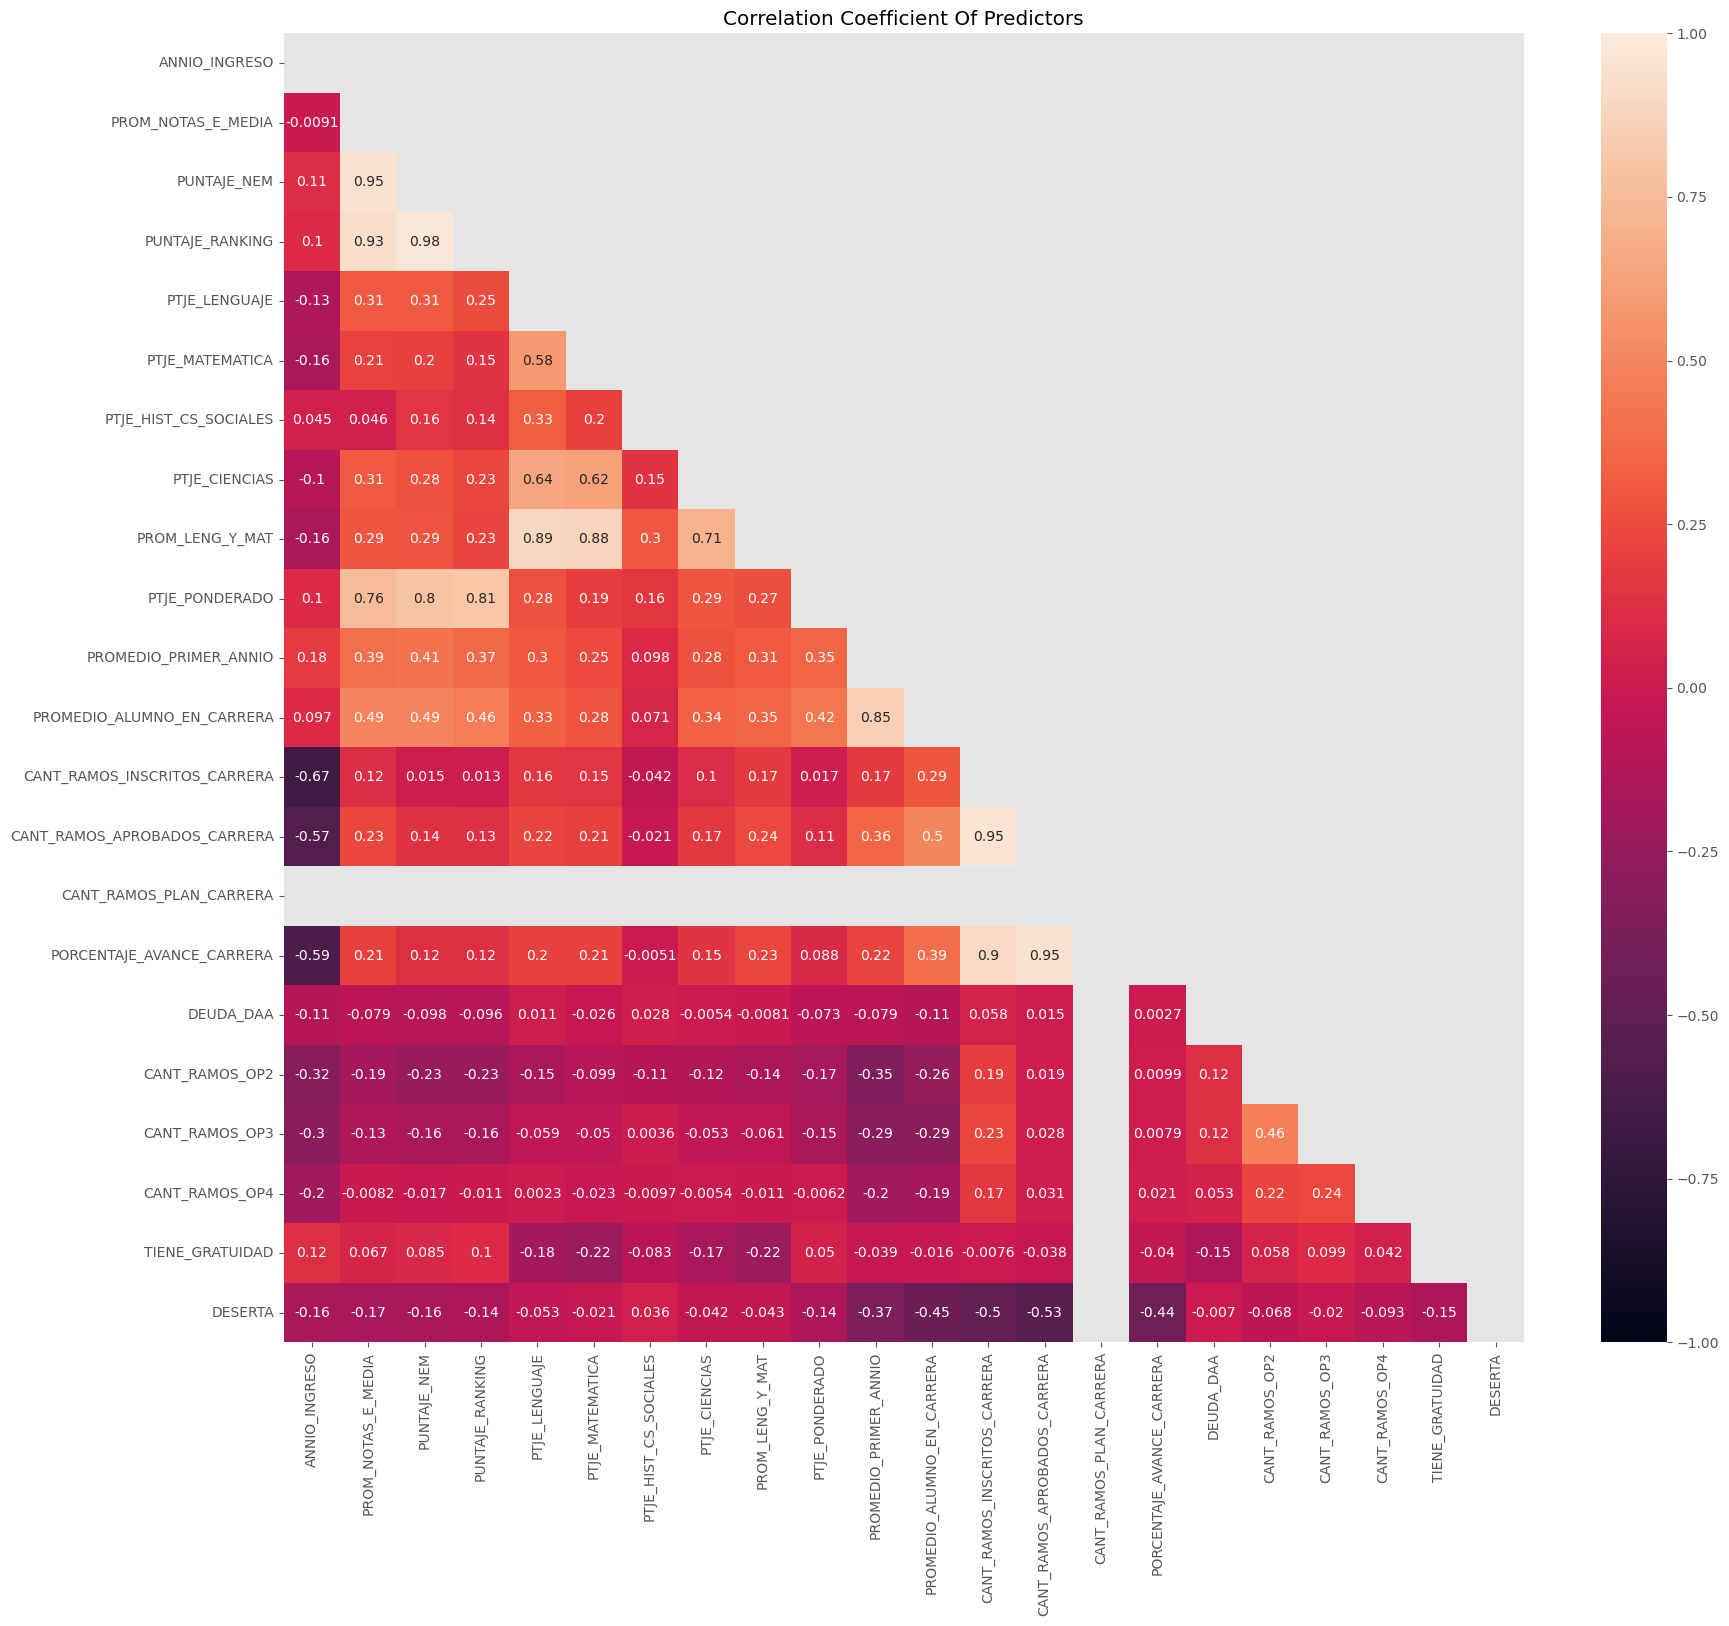

In [61]:
# set figure size
plt.figure(figsize=(20,17))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(datos_clean2.corr(), dtype=bool))

# generate heatmap
sns.heatmap(datos_clean2.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [62]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = datos_clean2[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [78]:
# features to consider removing
# considered_features = ['CANT_RAMOS_INSCRITOS_CARRERA',\
#         'PTJE_PONDERADO','PROM_NOTAS_E_MEDIA', \
#        'PTJE_MATEMATICA','PTJE_LENGUAJE', 'PTJE_CIENCIAS',\
#      'PROMEDIO_PRIMER_ANNIO', 'PROMEDIO_ALUMNO_EN_CARRERA' ]
considered_features = ['ANNIO_INGRESO',\
       'PROM_NOTAS_E_MEDIA',\
       'PTJE_LENGUAJE', 'PTJE_MATEMATICA',\
       'PTJE_HIST_CS_SOCIALES', 'PTJE_CIENCIAS',\
       'PTJE_PONDERADO', \
       'PROMEDIO_PRIMER_ANNIO',\
       'PROMEDIO_ALUMNO_EN_CARRERA',\
       'CANT_RAMOS_PLAN_CARRERA',\
       'PORCENTAJE_AVANCE_CARRERA', 'DEUDA_DAA', 'CANT_RAMOS_OP2',\
       'CANT_RAMOS_OP3', 'CANT_RAMOS_OP4', 'DESERTA']

# Eliminar por alta correlación
# 'PROM_LENG_Y_MAT','CANT_RAMOS_APROBADOS_CARRERA','PUNTAJE_NEM', 'PUNTAJE_RANKING' , 'PORCENTAJE_AVANCE_CARRERA',\
# compute vif ( vif>5 Sacar de a una variable)
#compute_vif(considered_features).sort_values('VIF', ascending=False)
compute_vif(considered_features).sort_values('VIF', ascending=False)


,Variable,VIF
8,PROMEDIO_ALUMNO_EN_CARRERA,5.46
10,PORCENTAJE_AVANCE_CARRERA,4.41
7,PROMEDIO_PRIMER_ANNIO,4.34
0,ANNIO_INGRESO,4.08
15,DESERTA,2.75
1,PROM_NOTAS_E_MEDIA,2.71
6,PTJE_PONDERADO,2.53
5,PTJE_CIENCIAS,2.16
2,PTJE_LENGUAJE,2.14
3,PTJE_MATEMATICA,1.85


Eliminar variables con alta correlación

In [ ]:
datos_clean2 = datos_clean2.drop(columns=["PROM_LENG_Y_MAT"])
datos_clean2 = datos_clean2.drop(columns=["PUNTAJE_RANKING"])
datos_clean2 = datos_clean2.drop(columns=["PUNTAJE_NEM"])
#datos_clean2 = datos_clean2.drop(columns=["PORCENTAJE_AVANCE_CARRERA"])
datos_clean2 = datos_clean2.drop(columns=["CANT_RAMOS_APROBADOS_CARRERA"])

datos_clean2 = datos_clean2.drop(columns=["CANT_RAMOS_PLAN_CARRERA"]) # no es significante 1 sola categoria

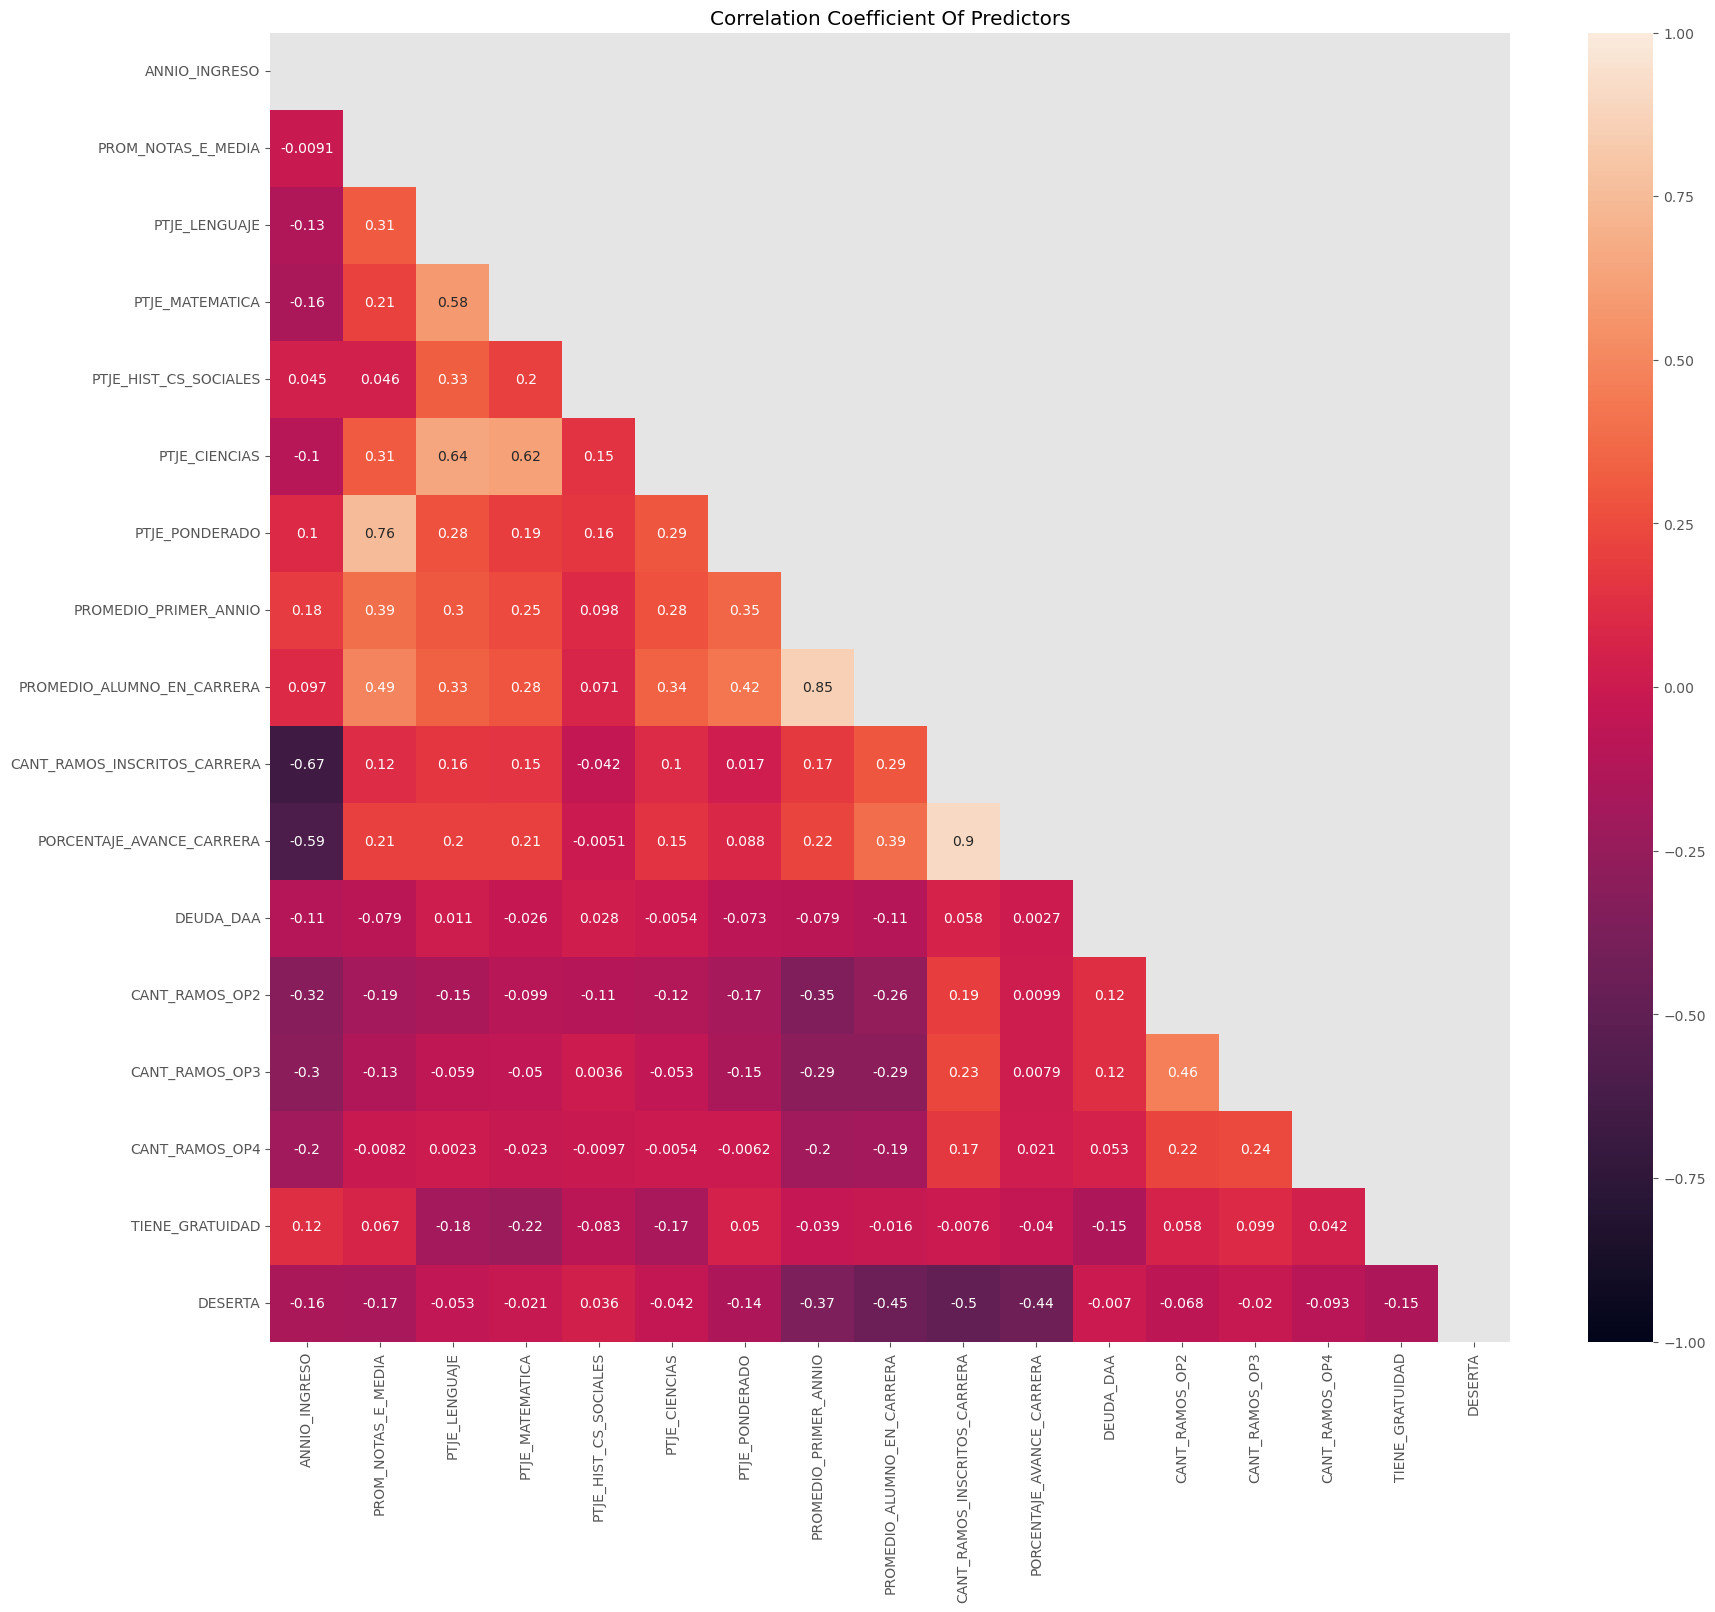

In [ ]:
# set figure size
plt.figure(figsize=(20,17))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(datos_clean2.corr(), dtype=bool))

# generate heatmap
sns.heatmap(datos_clean2.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

## Variables relevantes

In [ ]:

datos_clean2.columns.values.tolist()

['PERS_SEXO',
 'EDAD',
 'CODUA',
 'RAMA_EDUCACIONAL',
 'PROVINCIA_ESTAB_EDUC',
 'BEA',
 'GRUPO_DEPENDENCIA',
 'ANNIO_EGRESO_E_MEDIA',
 'PROM_NOTAS_E_MEDIA',
 'PTJE_LENGUAJE',
 'PTJE_MATEMATICA',
 'PTJE_HIST_CS_SOCIALES',
 'PTJE_CIENCIAS',
 'PTJE_PONDERADO',
 'SITUACION_EGRESO_EDUCACIONAL',
 'INGRESO_BRUTO_FAMILIAR',
 'PROMEDIO_PRIMER_ANNIO',
 'PROMEDIO_ALUMNO_EN_CARRERA',
 'CANT_RAMOS_INSCRITOS_CARRERA',
 'CANT_RAMOS_OP2',
 'CANT_RAMOS_OP3',
 'CANT_RAMOS_OP4',
 'DESERTA']